# Analysis of Operating Data on CSUDH Chillers

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = "data"
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)
os.listdir(data_dir)

['HistorianCompare.csv', 'HistorianCompare.pdf']

## Load CSV file

In [3]:
filename = 'HistorianCompare.csv'
df = pd.read_csv(os.path.join(data_dir, filename))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 19 columns):
 #   Column                                                           Non-Null Count  Dtype 
---  ------                                                           --------------  ----- 
 0   Timestamp                                                        8784 non-null   object
 1   Central Plant Chiller 1 Chiller Efficiency (kW/ton) (1)2024      6620 non-null   object
 2   Central Plant Chiller 1 Chiller Efficiency (kW/ton) (2)2022      8735 non-null   object
 3   Central Plant Chiller 2 Chiller Efficiency (kW/ton) (1)          6620 non-null   object
 4   Central Plant Chiller 2 Chiller Efficiency (kW/ton) (2)          8735 non-null   object
 5   Central Plant Chiller 3 Chiller Efficiency (kW/ton) (1)          6620 non-null   object
 6   Central Plant Chiller 3 Chiller Efficiency (kW/ton) (2)          8735 non-null   object
 7   Central Plant CHW Plant Chilled Water Efficiency (C

In [4]:
# This is used later
units = {}

## Strip placename and convert timestamps to datetimes

In [5]:
# Example
pd.to_datetime('2024-01-01T00:00:00-08:00 Los_Angeles'.removesuffix(' Los_Angeles'))

Timestamp('2024-01-01 00:00:00-0800', tz='UTC-08:00')

In [6]:
# Data has changing timezones and duplicates - example:
df['Timestamp'].iloc[1655:1665]

1655    2024-03-09T23:00:00-08:00 Los_Angeles
1656    2024-03-10T00:00:00-08:00 Los_Angeles
1657    2024-03-10T02:00:00-07:00 Los_Angeles
1658    2024-03-10T01:00:00-08:00 Los_Angeles
1659    2024-03-10T03:00:00-07:00 Los_Angeles
1660    2024-03-10T04:00:00-07:00 Los_Angeles
1661    2024-03-10T05:00:00-07:00 Los_Angeles
1662    2024-03-10T06:00:00-07:00 Los_Angeles
1663    2024-03-10T07:00:00-07:00 Los_Angeles
1664    2024-03-10T08:00:00-07:00 Los_Angeles
Name: Timestamp, dtype: object

In [7]:
if not df.index.name == 'Timestamp':
    time_stamps = pd.to_datetime(df['Timestamp'].str.removesuffix(' Los_Angeles'), utc=True)
    df['Timestamp'] = time_stamps
    df = df.set_index('Timestamp', drop=True).sort_index().drop_duplicates().tz_convert('America/Los_Angeles')
df.iloc[:5, 0:2]

,Central Plant Chiller 1 Chiller Efficiency (kW/ton) (1)2024,Central Plant Chiller 1 Chiller Efficiency (kW/ton) (2)2022
Timestamp,,
2024-01-01 00:00:00-08:00,0_kW/Ton,1.3596493403116863_kW/Ton
2024-01-01 01:00:00-08:00,0_kW/Ton,1.1398620903491974_kW/Ton
2024-01-01 02:00:00-08:00,0_kW/Ton,1.15005957086881_kW/Ton
2024-01-01 03:00:00-08:00,0_kW/Ton,1.1817961434523265_kW/Ton
2024-01-01 04:00:00-08:00,0_kW/Ton,0.8587031761805216_kW/Ton


## Simplify column names

In [8]:
if df.columns[0].startswith("Central Plant "):
    df.columns = [col.removeprefix("Central Plant ") for col in df]
if df.columns[6].startswith("CHW Plant "):
    df.columns = [col.removeprefix("CHW Plant ") for col in df]
df.columns

Index(['Chiller 1 Chiller Efficiency (kW/ton) (1)2024',
       'Chiller 1 Chiller Efficiency (kW/ton) (2)2022',
       'Chiller 2 Chiller Efficiency (kW/ton) (1)',
       'Chiller 2 Chiller Efficiency (kW/ton) (2)',
       'Chiller 3 Chiller Efficiency (kW/ton) (1)',
       'Chiller 3 Chiller Efficiency (kW/ton) (2)',
       'Chilled Water Efficiency (C) (1)', 'Chilled Water Efficiency (C) (2)',
       'Chilled Water Tons of Refrigeration (1)',
       'Chilled Water Tons of Refrigeration (2)', 'Chiller Stage (1)',
       'Chiller Stage (2)', 'Outside Air Temp (1)', 'Outside Air Temp (2)',
       'Total Power (1)', 'Total Power (2)',
       'Condenser Loop Wet Bulb Temp (1)', 'Condenser Loop Wet Bulb Temp (2)'],
      dtype='object')

In [9]:
# All other modifications to names
col_rename_map = {
    'Chiller 1 Chiller Efficiency (kW/ton) (1)2024': 'Chiller 1 Efficiency 2024',
    'Chiller 1 Chiller Efficiency (kW/ton) (2)2022': 'Chiller 1 Efficiency 2022',
    'Chiller 2 Chiller Efficiency (kW/ton) (1)': 'Chiller 2 Efficiency 2024',
    'Chiller 2 Chiller Efficiency (kW/ton) (2)': 'Chiller 2 Efficiency 2022',
    'Chiller 3 Chiller Efficiency (kW/ton) (1)': 'Chiller 3 Efficiency 2024',
    'Chiller 3 Chiller Efficiency (kW/ton) (2)': 'Chiller 3 Efficiency 2022',
    'Chilled Water Efficiency (C) (1)': 'Chilled Water Efficiency (C) 2024',
    'Chilled Water Efficiency (C) (2)': 'Chilled Water Efficiency (C) 2022',
    'Chilled Water Tons of Refrigeration (1)': 'Chilled Water Tons of Refrigeration 2024',
    'Chilled Water Tons of Refrigeration (2)': 'Chilled Water Tons of Refrigeration 2022',
    'Chiller Stage (1)': 'Chiller Stage 2024',
    'Chiller Stage (2)': 'Chiller Stage 2022',
    'Outside Air Temp (1)': 'Outside Air Temp 2024',
    'Outside Air Temp (2)': 'Outside Air Temp 2022',
    'Total Power (1)': 'Total Power 2024',
    'Total Power (2)': 'Total Power 2022',
    'Condenser Loop Wet Bulb Temp (1)': 'Condenser Loop Wet Bulb Temp 2024',
    'Condenser Loop Wet Bulb Temp (2)': 'Condenser Loop Wet Bulb Temp 2022'
}

df = df.rename(columns=col_rename_map)
df.columns

Index(['Chiller 1 Chiller Efficiency (kW/ton) 2024',
       'Chiller 1 Chiller Efficiency (kW/ton) 2022',
       'Chiller 2 Chiller Efficiency (kW/ton) 2024',
       'Chiller 2 Chiller Efficiency (kW/ton) 2022',
       'Chiller 3 Chiller Efficiency (kW/ton) 2024',
       'Chiller 3 Chiller Efficiency (kW/ton) 2022',
       'Chilled Water Efficiency (C) 2024',
       'Chilled Water Efficiency (C) 2022',
       'Chilled Water Tons of Refrigeration 2024',
       'Chilled Water Tons of Refrigeration 2022', 'Chiller Stage 2024',
       'Chiller Stage 2022', 'Outside Air Temp 2024', 'Outside Air Temp 2022',
       'Total Power 2024', 'Total Power 2022',
       'Condenser Loop Wet Bulb Temp 2024',
       'Condenser Loop Wet Bulb Temp 2022'],
      dtype='object')

## Separate data and units of measure

In [10]:
df.dtypes

Chiller 1 Chiller Efficiency (kW/ton) 2024    object
Chiller 1 Chiller Efficiency (kW/ton) 2022    object
Chiller 2 Chiller Efficiency (kW/ton) 2024    object
Chiller 2 Chiller Efficiency (kW/ton) 2022    object
Chiller 3 Chiller Efficiency (kW/ton) 2024    object
Chiller 3 Chiller Efficiency (kW/ton) 2022    object
Chilled Water Efficiency (C) 2024             object
Chilled Water Efficiency (C) 2022             object
Chilled Water Tons of Refrigeration 2024      object
Chilled Water Tons of Refrigeration 2022      object
Chiller Stage 2024                            object
Chiller Stage 2022                            object
Outside Air Temp 2024                         object
Outside Air Temp 2022                         object
Total Power 2024                              object
Total Power 2022                              object
Condenser Loop Wet Bulb Temp 2024             object
Condenser Loop Wet Bulb Temp 2022             object
dtype: object

In [28]:
units_rename_map = {'_kW/Ton': 'kW/ton', 'kW/ton': 'kW/ton', '_Ton': 'ton', '°F': '°F', 'kW':'kW'}

for col in df:
    if df[col].dtype == 'object':
        not_nan_values = ~df[col].isna()
        for units_str, renamed_units in units_rename_map.items():
            matches = df[col].str.endswith(units_str)
            if matches.any():
                print(f"Converting column: {col}")
                df.loc[not_nan_values & matches, col] = \
                    df.loc[not_nan_values & matches, col] \
                    .str.removesuffix(units_str)
                df[col] = pd.to_numeric(df[col])
                units[col] = renamed_units
                break

pd.Series(units)

Chiller 1 Chiller Efficiency (kW/ton) 2024    kW/ton
Chiller 1 Chiller Efficiency (kW/ton) 2022    kW/ton
Chiller 2 Chiller Efficiency (kW/ton) 2024    kW/ton
Chiller 2 Chiller Efficiency (kW/ton) 2022    kW/ton
Chiller 3 Chiller Efficiency (kW/ton) 2024    kW/ton
Chiller 3 Chiller Efficiency (kW/ton) 2022    kW/ton
Chilled Water Efficiency (C) 2024             kW/ton
Chilled Water Efficiency (C) 2022             kW/ton
Chilled Water Tons of Refrigeration 2024         ton
Chilled Water Tons of Refrigeration 2022         ton
Outside Air Temp 2024                             °F
Outside Air Temp 2022                             °F
Total Power 2024                                  kW
Total Power 2022                                  kW
Condenser Loop Wet Bulb Temp 2024                 °F
Condenser Loop Wet Bulb Temp 2022                 °F
dtype: object

In [12]:
# These columns contain strange data
df['Chiller Stage 2024'].value_counts().head(25)

Chiller Stage 2024
AAAB        3510
AAAA        2155
AAAC         238
AAABAAAA     179
AAAAAAAB     137
AAAAAeAB      61
AAAAAMAB      10
AAABABAA      10
AAAAAqAB       7
AAABAUAA       6
AAABADAA       6
AAABAIAA       6
AAAAALAB       6
AAABAdAA       5
AAAAAZAB       5
AAAAARAB       5
AAABAcAA       5
AAAAATAB       5
AAABAFAA       5
AAABAEAA       5
AAAAAcAB       5
AAABALAA       4
AAABAKAA       4
AAABAVAA       4
AAAAAFAB       4
Name: count, dtype: int64

In [13]:
df['Chiller Stage 2022'].value_counts().head(25)

Chiller Stage 2022
AAAB        7999
AAAC         468
AAAA          39
AAAD          26
AAACAyAB       8
AAACARAB       5
AAACAEAB       5
AAABAcAC       4
AAABAoAC       4
AAADAzAC       3
AAACAXAB       3
AAACAWAB       3
AAABAPAC       3
AAACADAB       3
AAABA4AC       3
AAABAfAC       3
AAABADAC       3
AAABA1AC       3
AAACAzAB       3
AAABAEAC       3
AAABAOAC       3
AAABARAC       3
AAACAJAB       3
AAABANAC       3
AAACAOAB       2
Name: count, dtype: int64

In [14]:
# Try clipping to first 4 chars:
chiller_stage_cols = {
    2024: 'Chiller Stage 2024', 
    2022: 'Chiller Stage 2022'
}
for year, col in chiller_stage_cols.items():
    df[col] = df[col].str.slice(0, 4)
    print(df[col].value_counts().head(5))

Chiller Stage 2024
AAAB    3916
AAAA    2504
AAAC     293
Name: count, dtype: int64
Chiller Stage 2022
AAAB    8111
AAAC     565
AAAA      48
AAAD      35
Name: count, dtype: int64


In [15]:
stages_rename_map = {
    "AAAB": 1, 
    "AAAA": 1,
    "AAAC": 2, 
    "AAAD": 3
}

In [16]:
for col in chiller_stage_cols.values():
    df[col] = df[col].map(stages_rename_map)
    print(df[col].value_counts().head(5))

Chiller Stage 2024
1.0    6420
2.0     293
Name: count, dtype: int64
Chiller Stage 2022
1.0    8159
2.0     565
3.0      35
Name: count, dtype: int64


## Make some plots

In [17]:
colors = {2024: "tab:blue", 2022: "tab:orange"}

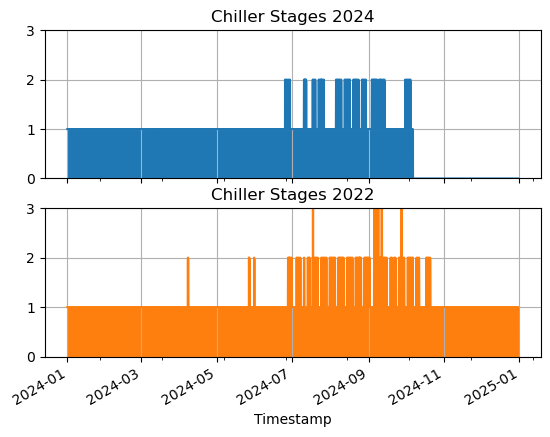

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, chiller_stage_cols.items()):
    df[col].plot.area(ax=ax, color=colors[year], ylim=[0, 3], 
                      grid=True, title=f"Chiller Stages {year}")

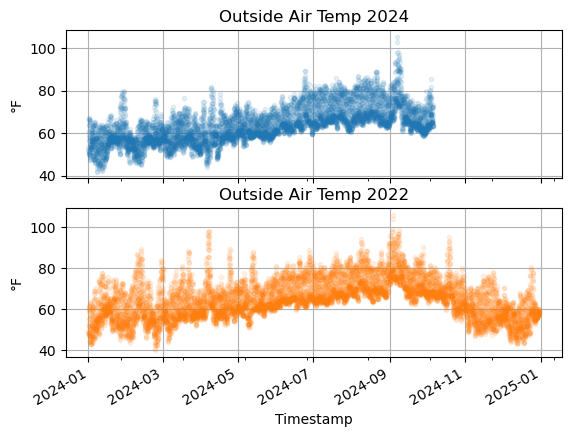

In [19]:
amb_air_temp_cols = {
    2024: "Outside Air Temp 2024",
    2022: "Outside Air Temp 2022"
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, amb_air_temp_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.1, 
                 ylabel=units[col], grid=True, title=col)

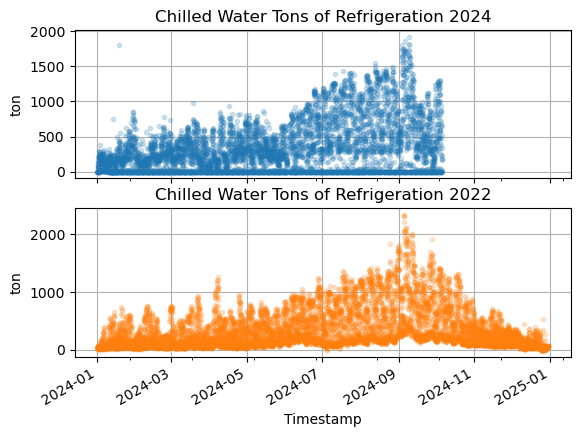

In [20]:
chilled_water_tons_cols = {
    2024: "Chilled Water Tons of Refrigeration 2024",
    2022: "Chilled Water Tons of Refrigeration 2022"
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, chilled_water_tons_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.2, 
                 ylabel=units[col], grid=True, title=col)

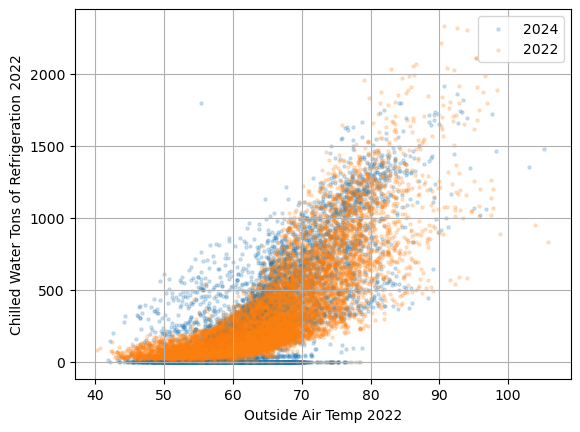

In [21]:
fig, ax = plt.subplots()
for year in amb_air_temp_cols.keys():
    x_label = amb_air_temp_cols[year]
    y_label = chilled_water_tons_cols[year]
    df.plot.scatter(x=x_label, y=y_label, ax=ax, marker='.', 
                    color=colors[year], alpha=0.2, grid=True,
                    label=year)
plt.show()

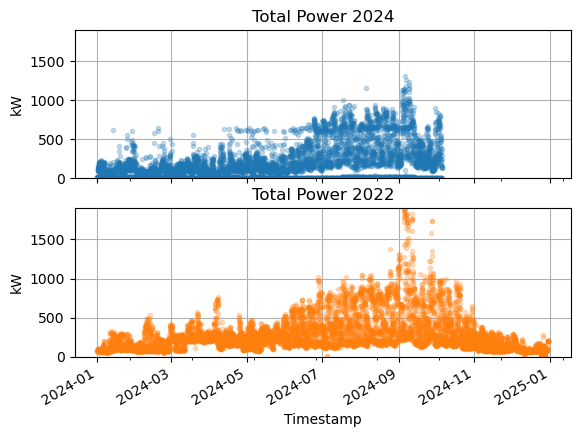

In [22]:
total_power_cols = {
    2024: "Total Power 2024",
    2022: "Total Power 2022"
}

max_power = max(df[col].max() for col in total_power_cols.values())

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, total_power_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.25, 
                 ylabel=units[col], ylim=[0, max_power], 
                 grid=True, title=col)

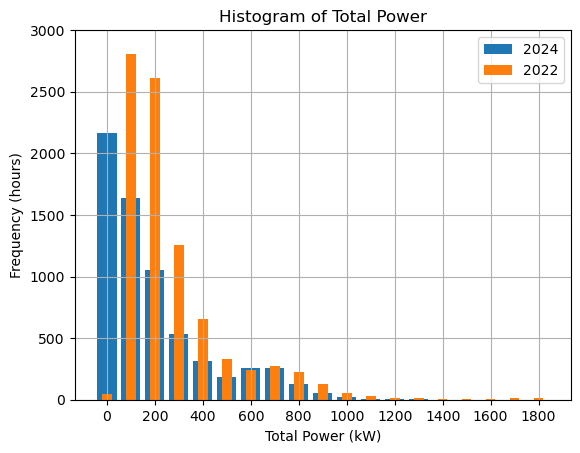

In [23]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
bin_centers = np.linspace(0, 1900, 20)
bins = bin_centers - 50.0
for (year, col), bar_width in zip(total_power_cols.items(), [0.8, 0.4]):
    df[col].hist(ax=ax, bins=bins, histtype='barstacked', 
                 rwidth=bar_width, color=colors[year], label=year)
ax.set_xticks(bin_centers[::2])
ax.set_xticklabels(bin_centers[::2])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_ylim([0, 3000])
ax.set_xlabel(f'Total Power ({units[col]})')
ax.set_ylabel('Frequency (hours)')
ax.set_title("Histogram of Total Power")
ax.legend()
plt.show()

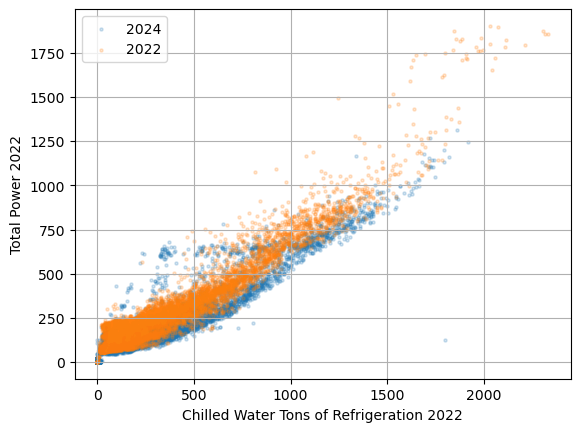

In [24]:
fig, ax = plt.subplots()
for year in chilled_water_tons_cols.keys():
    x_label = chilled_water_tons_cols[year]
    y_label = total_power_cols[year]
    df.plot.scatter(x=x_label, y=y_label, ax=ax, marker='.', 
                    color=colors[year], alpha=0.2, grid=True,
                    label=year)
plt.show()

In [25]:
df['Hour of day'] = df.index.hour
df_by_hour_of_day = df.groupby('Hour of day').mean()
df_by_hour_of_day.head()

,Chiller 1 Chiller Efficiency (kW/ton) 2024,Chiller 1 Chiller Efficiency (kW/ton) 2022,Chiller 2 Chiller Efficiency (kW/ton) 2024,Chiller 2 Chiller Efficiency (kW/ton) 2022,Chiller 3 Chiller Efficiency (kW/ton) 2024,Chiller 3 Chiller Efficiency (kW/ton) 2022,Chilled Water Efficiency (C) 2024,Chilled Water Efficiency (C) 2022,Chilled Water Tons of Refrigeration 2024,Chilled Water Tons of Refrigeration 2022,Chiller Stage 2024,Chiller Stage 2022,Outside Air Temp 2024,Outside Air Temp 2022,Total Power 2024,Total Power 2022,Condenser Loop Wet Bulb Temp 2024,Condenser Loop Wet Bulb Temp 2022
Hour of day,,,,,,,,,,,,,,,,,,
0,0.000192,0.223737,0.002024,0.287876,0.001817,0.182107,0.006861,1.558936,1.276199,107.047400,1.000000,1.000000,60.148617,60.668745,11.469103,140.573044,55.861427,55.207112
1,0.005391,0.214635,0.000826,0.279573,0.005065,0.174941,0.016021,1.507165,21.141699,108.687805,1.000000,1.005464,59.759339,60.167623,29.800598,140.545348,55.640448,54.887658
2,0.008718,0.226175,0.003696,0.281589,0.009811,0.177728,0.030763,1.524249,35.577523,105.143564,1.000000,1.000000,59.432942,59.743435,51.799354,137.758966,55.461165,54.661578
3,0.025845,0.228645,0.007666,0.290970,0.015061,0.176688,0.061166,1.557638,87.261305,100.953021,1.003571,1.000000,59.095993,59.333905,90.884870,135.644559,55.257045,54.368320
4,0.038963,0.198316,0.005371,0.242150,0.021026,0.156949,0.084086,1.232230,107.310787,139.786562,1.007143,1.000000,58.867994,58.997154,112.217324,158.482815,55.075506,54.096893


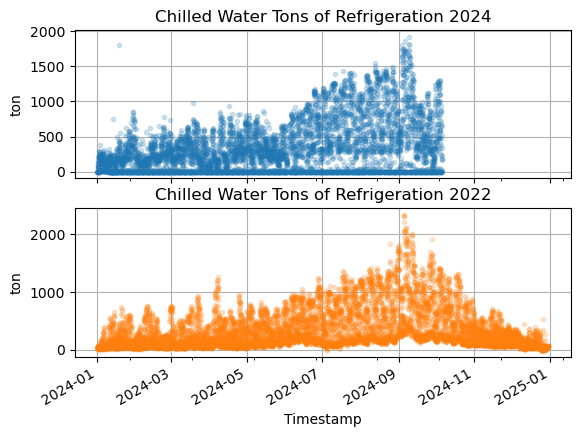

In [26]:
chilled_water_efficiency_cols = {
    2024: "Chilled Water Efficiency (C) 2024",
    2022: "Chilled Water Efficiency (C) 2022"
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, chilled_water_tons_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.2, 
                 ylabel=units[col], grid=True, title=col)

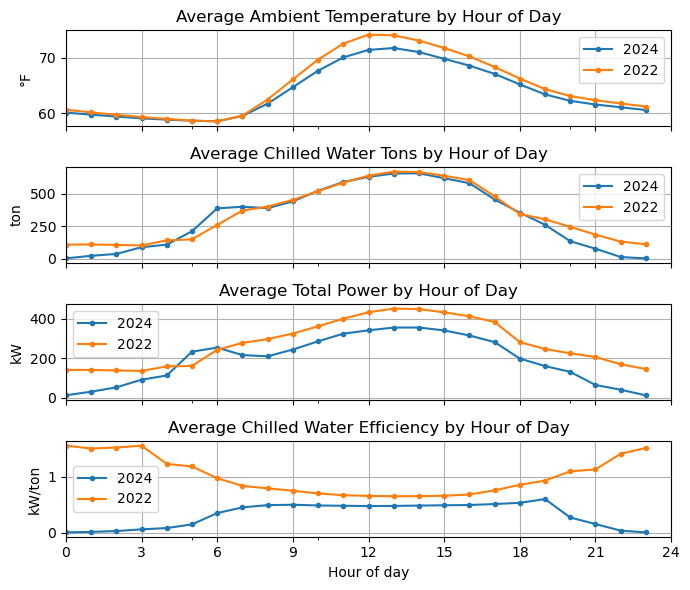

In [27]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(7, 6))
for year in total_power_cols.keys():

    col = amb_air_temp_cols[year]
    df_by_hour_of_day[col].plot(
        ax=axes[0], style='.-', color=colors[year], grid=True, 
        title='Average Ambient Temperature by Hour of Day', label=year,
        ylabel=units[col], legend=True
    )

    col = chilled_water_tons_cols[year]
    df_by_hour_of_day[col].plot(
        ax=axes[1], style='.-', color=colors[year], grid=True, 
        title='Average Chilled Water Tons by Hour of Day', label=year, 
        ylabel=units[col], legend=True
    )

    col = total_power_cols[year]
    df_by_hour_of_day[col].plot(
        ax=axes[2], style='.-', color=colors[year], grid=True, 
        title='Average Total Power by Hour of Day', label=year, 
        ylabel=units[col], legend=True
    )

    col = chilled_water_efficiency_cols[year]
    df_by_hour_of_day[col].plot(
        ax=axes[3], style='.-', color=colors[year], grid=True, 
        title='Average Chilled Water Efficiency by Hour of Day', label=year, 
        ylabel=units[col], legend=True
    )

for ax in axes:
    ax.set_xticks(list(range(0, 25, 3)))
    ax.set_xlim([0, 24])
plt.tight_layout()
filename = "averages_by_hour_of_day.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

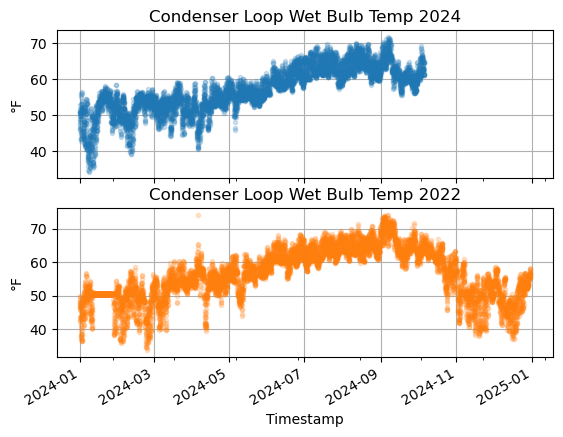

In [30]:
condenser_loop_wbt_cols = {
    2024: 'Condenser Loop Wet Bulb Temp 2024',
    2022: 'Condenser Loop Wet Bulb Temp 2022'
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, condenser_loop_wbt_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.2, 
                 ylabel=units[col], grid=True, title=col)

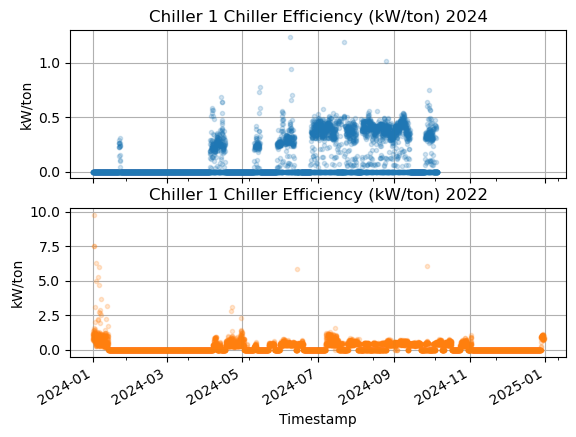

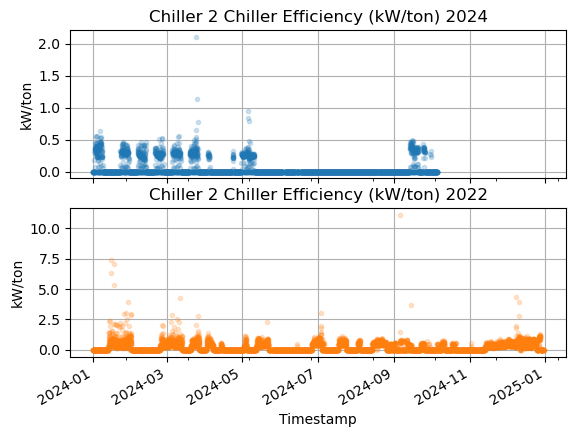

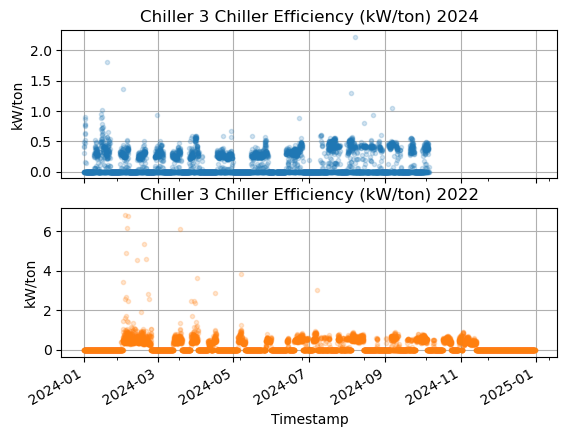

In [29]:
chiller_efficiency_cols = {
    1: {
        2024: "Chiller 1 Chiller Efficiency (kW/ton) 2024",
        2022: "Chiller 1 Chiller Efficiency (kW/ton) 2022"
    },
    2: {
        2024: "Chiller 2 Chiller Efficiency (kW/ton) 2024",
        2022: "Chiller 2 Chiller Efficiency (kW/ton) 2022"
    },
    3: {
        2024: "Chiller 3 Chiller Efficiency (kW/ton) 2024",
        2022: "Chiller 3 Chiller Efficiency (kW/ton) 2022"
    }
}

for chiller in chiller_efficiency_cols:
    fig, axes = plt.subplots(2, 1, sharex=True)
    for ax, (year, col) in zip(axes, chiller_efficiency_cols[chiller].items()):
        df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.2, 
                     ylabel=units[col], grid=True, title=col)
    plt.show()

In [31]:
# Chiller efficiency data may be a proxy for 'chiller is operating'
